In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
import importlib
for module in ['kooplearn', 'matplotlib']:
    try:
        importlib.import_module(module)
    except ImportError:
        %pip install {module}
import kooplearn
from sklearn.gaussian_process.kernels import RBF
from kooplearn.models import NystroemKernel
from kooplearn.data import traj_to_contexts
from sklearn.preprocessing import StandardScaler

In [2]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/Dynamical_system/data')
data_2019 = pd.read_csv('data_2019.csv',sep=';')
data_2020 = pd.read_csv('data_2020.csv',sep=';')
data_2021 = pd.read_csv('data_2021.csv',sep=';')
data_2022 = pd.read_csv('data_2022.csv',sep=';')
prices = pd.read_csv('France.csv')
os.chdir(actual_path)
%run functions.ipynb

/tmp/ipykernel_20476/1494444423.py:5: DtypeWarning: Columns (36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2021 = pd.read_csv('data_2021.csv',sep=';')


In [3]:
whole_data = pd.concat([data_2019,data_2020,data_2021,data_2022])

In [4]:
whole_data = whole_data.reset_index(drop=True)

In [5]:
list_to_drop = ['Périmètre','Prévision J-1','Prévision J',
                ' Stockage batterie',
                'Déstockage batterie','Eolien terrestre',
                'Eolien offshore',
                'Unnamed: 40','Nature']
#the variables related to the batteries and both the ones 
#containing informations about offshore and onshore
#wind are deleted because they only contain NaN values

In [6]:
use_data = whole_data.drop(list_to_drop,axis=1).copy()

In [7]:
use_data = use_data.dropna()

In [8]:
use_data.loc[:, 'Heures'] = use_data['Heures'].apply(lambda x: f"{x}:00" if len(x.split(':')) == 2 else x)
use_data['Heures'] = pd.to_timedelta(use_data['Heures'])

In [9]:
use_data['date'] = pd.to_datetime(use_data['Date']) + use_data['Heures']

In [10]:
use_data.drop(['Heures'],axis=1,inplace=True)

In [11]:
prices_period = prices[prices['Datetime (Local)'] >= '2019-01-01 00:00:00'].copy()

In [12]:
prices_period

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
35063,France,FRA,2018-12-31 23:00:00,2019-01-01 00:00:00,51.00
35064,France,FRA,2019-01-01 00:00:00,2019-01-01 01:00:00,46.27
35065,France,FRA,2019-01-01 01:00:00,2019-01-01 02:00:00,39.78
35066,France,FRA,2019-01-01 02:00:00,2019-01-01 03:00:00,27.87
35067,France,FRA,2019-01-01 03:00:00,2019-01-01 04:00:00,23.21
...,...,...,...,...,...
87617,France,FRA,2024-12-29 17:00:00,2024-12-29 18:00:00,134.40
87618,France,FRA,2024-12-29 18:00:00,2024-12-29 19:00:00,133.72
87619,France,FRA,2024-12-29 19:00:00,2024-12-29 20:00:00,123.92
87620,France,FRA,2024-12-29 20:00:00,2024-12-29 21:00:00,118.59


In [13]:
prices_period.drop(['Country','ISO3 Code','Datetime (UTC)'],axis=1,inplace=True)

In [14]:
prices_period['Datetime (Local)'] = pd.to_datetime(prices_period['Datetime (Local)'])
whole_period = prices_period.merge(use_data,how='left',left_on='Datetime (Local)',
                                  right_on='date')

In [15]:
whole_period.drop('Datetime (Local)',axis=1,inplace=True)

In [16]:
whole_period.columns

Index(['Price (EUR/MWhe)', 'Date', 'Consommation', 'Fioul', 'Charbon', 'Gaz',
       'Nucléaire', 'Eolien', 'Solaire', 'Hydraulique', 'Pompage',
       'Bioénergies', 'Ech. physiques', 'Taux de Co2', 'Ech. comm. Angleterre',
       'Ech. comm. Espagne', 'Ech. comm. Italie', 'Ech. comm. Suisse',
       'Ech. comm. Allemagne-Belgique', 'Fioul - TAC', 'Fioul - Cogén.',
       'Fioul - Autres', 'Gaz - TAC', 'Gaz - Cogén.', 'Gaz - CCG',
       'Gaz - Autres', 'Hydraulique - Fil de l?eau + éclusée',
       'Hydraulique - Lacs', 'Hydraulique - STEP turbinage',
       'Bioénergies - Déchets', 'Bioénergies - Biomasse',
       'Bioénergies - Biogaz', 'date'],
      dtype='object')

In [17]:
whole_period.columns = ['price','date_wo_h','conso','fioul','coal','gas',
                       'nuclear','wind','sun','hydro','pump','bioenergy','physics',
                        'exchange_uk','exchange_sp','exchange_it','exchange_sw',
                        'exchange_gr','co2_rate','fioul_tac','fioul_cogen',
                        'fioul_other','gas_tac',
                       'gas_cogen','gas_ccg','gas_other','hydro_river','hydro_lake',
                       'hydro_turbine','bio_waste','bio_biomass','bio_biogas','date']

In [18]:
whole_period.dropna(inplace=True)

In [19]:
#whole_period['target_date'] = whole_period['date'] + timedelta(days=1)

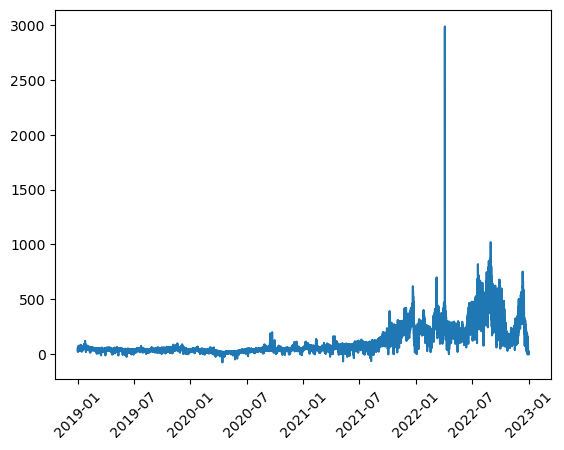

In [20]:
fig, ax = plt.subplots()
ax.plot(whole_period['date'],whole_period['price'])
ax.tick_params(axis='x', labelrotation=45)

In [21]:
whole_period['cos_day'] = whole_period['date'].dt.day.astype(float)
whole_period['sin_day'] = whole_period['date'].dt.day.astype(float)
whole_period['cos_month'] = whole_period['date'].dt.month.astype(float)
whole_period['sin_month'] = whole_period['date'].dt.month.astype(float)

In [22]:
whole_period['cos_day'] = cos_transformer(365).fit_transform(whole_period['cos_day'])
whole_period['cos_month'] = cos_transformer(12).fit_transform(whole_period['cos_month'])
whole_period['sin_day'] = sin_transformer(365).fit_transform(whole_period['sin_day'])
whole_period['sin_month'] = sin_transformer(12).fit_transform(whole_period['sin_month'])

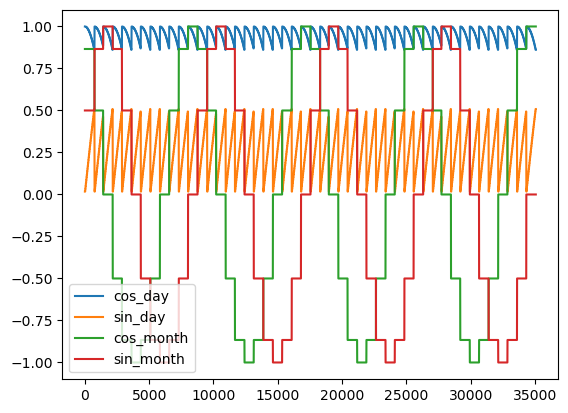

In [23]:
fig, ax = plt.subplots()
for i in ['cos_day','sin_day','cos_month','sin_month']:
    ax.plot(whole_period[f'{i}'],label=f'{i}')
    ax.legend()

In [24]:
#whole_period[whole_period['date'] < '2019-01-02 01:00:00' & whole_period['date'] <'2019-01-03 01:00:00' ]

In [25]:
whole_period['weekdays'] = whole_period['date'].dt.dayofweek
whole_period['weekend'] = np.zeros(whole_period.shape[0])
whole_period['not_weekend'] = np.zeros(whole_period.shape[0])
whole_period['date_wo_h'] = pd.to_datetime(whole_period['date_wo_h'])

In [26]:
for i in range(whole_period.shape[0]):
    if whole_period.loc[i,'weekdays'] == 5 or whole_period.loc[i,'weekdays'] == 6:
        whole_period.loc[i,'weekend'] = 1
    else:
        whole_period.loc[i,'not_weekend'] = 1

In [27]:
#we need to add the 2 days lagged of fossil fuel and nuclear production
#we cannot add what they call the announced availability because they don't 
#describe how they find it and on the majority of ressources concerning 
#the matter, we only have access to the effective production

In [28]:
whole_period['2_lags_coal'] = whole_period['coal'].shift(48)
whole_period['2_lags_fioul'] = whole_period['fioul'].shift(48)
whole_period['2_lags_gas'] = whole_period['gas'].shift(48)
whole_period['2_lags_nuke'] = whole_period['nuclear'].shift(48)
whole_period['target_price'] = whole_period['price'].shift(24)

In [29]:
whole_period.dropna(inplace=True) #we just loose two days

In [30]:
whole_period.columns

Index(['price', 'date_wo_h', 'conso', 'fioul', 'coal', 'gas', 'nuclear',
       'wind', 'sun', 'hydro', 'pump', 'bioenergy', 'physics', 'exchange_uk',
       'exchange_sp', 'exchange_it', 'exchange_sw', 'exchange_gr', 'co2_rate',
       'fioul_tac', 'fioul_cogen', 'fioul_other', 'gas_tac', 'gas_cogen',
       'gas_ccg', 'gas_other', 'hydro_river', 'hydro_lake', 'hydro_turbine',
       'bio_waste', 'bio_biomass', 'bio_biogas', 'date', 'cos_day', 'sin_day',
       'cos_month', 'sin_month', 'weekdays', 'weekend', 'not_weekend',
       '2_lags_coal', '2_lags_fioul', '2_lags_gas', '2_lags_nuke',
       'target_price'],
      dtype='object')

In [31]:
training_data = whole_period[whole_period['date_wo_h'].dt.year < 2022].copy()
test_data = whole_period[whole_period['date_wo_h'].dt.year == 2022].copy()
list_imp_hours = [3,8,13,18,23]

In [32]:
training_data.drop(['date_wo_h','price'],axis=1,inplace=True)
test_data.drop(['date_wo_h','price'],axis=1,inplace=True)

In [33]:
training_data = training_data[training_data['date'].dt.hour.isin(list_imp_hours)]
test_data = test_data[test_data['date'].dt.hour.isin(list_imp_hours)]
for_plots_date = test_data['date']
for_plots_train = training_data['date']

In [34]:
list_imp = list(training_data.columns)
list_imp.remove('date')
#['nuclear','2_lags_nuke','coal','exchange_uk','fioul','target_price']
y_train = np.array(training_data['target_price'])
y_test = np.array(test_data['target_price'])

koop_train = training_data[list_imp].copy()
koop_test = test_data[list_imp].copy()
koop_train['target_last'] = koop_train['target_price'].copy()
koop_test['target_last'] = koop_test['target_price'].copy()
koop_train.drop(['target_price'],axis=1,inplace=True)
koop_test.drop(['target_price'],axis=1,inplace=True)
scaler_koop = StandardScaler().fit(koop_train)
koop_train = scaler_koop.transform(koop_train)
koop_test = scaler_koop.transform(koop_test)
training_data.drop(['target_price','date'],axis=1,inplace=True)
test_data.drop(['target_price','date'],axis=1,inplace=True)

In [35]:
quantile_reg_05 = QuantileRegressor(quantile=0.05).fit(X=training_data,
                                                      y=y_train)
quantile_reg_95 = QuantileRegressor(quantile=0.95).fit(X=training_data,
                                                      y=y_train)

In [36]:
predictions_05 = quantile_reg_05.predict(X=test_data)
predictions_95 = quantile_reg_95.predict(X=test_data)

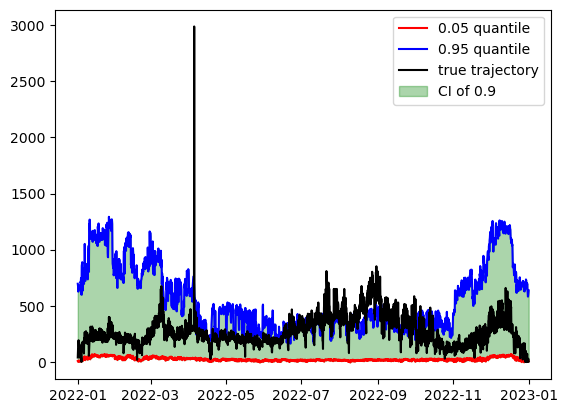

In [37]:
fig, ax = plt.subplots()
ax.plot(for_plots_date,predictions_05,'r-',label='0.05 quantile')
ax.plot(for_plots_date,predictions_95,'b-',label='0.95 quantile')
ax.plot(for_plots_date,y_test,'k-',label='true trajectory')
ax.fill_between(x=for_plots_date,y1=predictions_05,y2=predictions_95,color='green',alpha=0.33,label='CI of 0.9')
plt.legend()

In [38]:
true_val = y_test
empirical = 0
for i in range(true_val.shape[0]):
    if true_val[i] < predictions_95[i] and true_val[i] > predictions_05[i]:
        empirical += 1
empirical /= true_val.shape[0]

In [39]:
empirical

0.7742465753424658

In [40]:
np.mean(predictions_95-predictions_05)

np.float64(535.7115042444534)

In [41]:
gbr_05 = GradientBoostingRegressor(loss='quantile',
                                   alpha=0.05, n_estimators=200).fit(X=training_data,
                                                         y=y_train)
gbr_95 = GradientBoostingRegressor(loss='quantile',
                                   alpha=0.95,n_estimators=200).fit(X=training_data,
                                                         y=y_train)
predictions_gbr_05 = gbr_05.predict(X=test_data)
predictions_gbr_95 = gbr_95.predict(X=test_data)

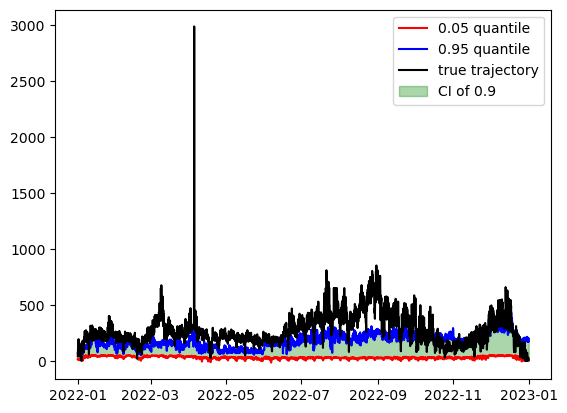

In [42]:
fig, ax = plt.subplots()
ax.plot(for_plots_date,predictions_gbr_05,'r-',label='0.05 quantile')
ax.plot(for_plots_date,predictions_gbr_95,'b-',label='0.95 quantile')
ax.plot(for_plots_date,y_test,'k-',label='true trajectory')
ax.fill_between(x=for_plots_date,y1=predictions_gbr_05,y2=predictions_gbr_95,color='green',alpha=0.33,label='CI of 0.9')
plt.legend()

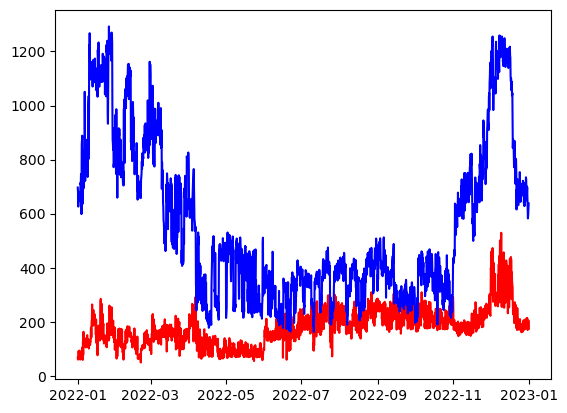

In [43]:
plt.plot(for_plots_date,predictions_gbr_95,'r-')
plt.plot(for_plots_date,predictions_95,'b-')

In [44]:
emp_cov_gbr = empirical_coverage(true_value=y_test,
                                 lower_bound=predictions_gbr_05,
                                upper_bound=predictions_gbr_95)

In [45]:
emp_cov_gbr

0.19123287671232878

In [46]:
tr_contexts = kooplearn.data.traj_to_contexts(koop_train,context_window_len=10,time_lag=1,backend='numpy')
test_contexts = kooplearn.data.traj_to_contexts(koop_test,context_window_len=10,time_lag=1,backend='numpy')

In [47]:
actual_target = koop_train.shape[1] - 1
kernel = RBF(length_scale=0.5)
nys_rrr = NystroemKernel(kernel=kernel,reduced_rank=True,tikhonov_reg=1e-8,rank=10,num_centers=500)
nys_rrr.fit(tr_contexts)
pred = nys_rrr.predict(tr_contexts)
true = tr_contexts.lookforward(nys_rrr.lookback_len)
rmse = np.sqrt(np.mean((pred - true)**2))

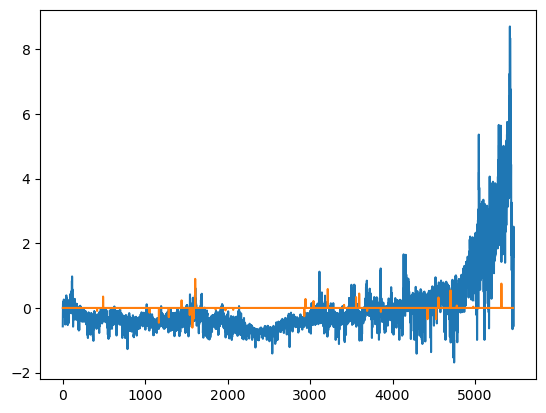

In [48]:
plt.plot(koop_train[:,actual_target])
plt.plot(pred[:,0,actual_target])

In [50]:
import kooplearn.data as kdata  # Using kooplearn.data to handle contexts

# Moving average function for numpy arrays
def moving_average(data, window_size):
    """
    Apply a moving average to smooth the data.
    Parameters:
        data (numpy.ndarray): Input data array of shape (n_samples, n_features).
        window_size (int): Size of the moving window.
    Returns:
        numpy.ndarray: Smoothed data array.
    """
    cumsum = np.cumsum(np.insert(data, 0, 0, axis=0), axis=0)
    smoothed_data = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    return smoothed_data

# Iterative forecasting function
def iterative_forecast(model, initial_context, forecast_steps):
    """
    Perform iterative forecasting using the Koopman operator model.
    Parameters:
        model: Trained Koopman operator model.
        initial_context (TensorContextDataset): Initial context dataset for forecasting.
        forecast_steps (int): Number of steps to forecast iteratively.
    Returns:
        numpy.ndarray: Predicted values for the forecast steps.
    """
    context = initial_context  # Start with the initial context
    predictions = []

    for _ in range(forecast_steps):
        # Predict the next step using the model
        pred = model.predict(context)
        predictions.append(pred[-1])  # Append the latest prediction
        
        # Manually update context with the predicted step
        new_context_data = np.roll(context.data, -1, axis=1)  # Shift the context by one time step
        new_context_data[:, -1] = pred[-1]  # Append the predicted value as the last element
        
        # Create a new TensorContextDataset with updated context
        context = kdata.TensorContextDataset(new_context_data)  # We no longer need to pass time_lag or context_length

    return np.array(predictions)


# Smooth the data to reduce noise
window_size = 10
koop_train_smoothed = moving_average(koop_train, window_size)
koop_test_smoothed = moving_average(koop_test, window_size)

# Standardize the data
scaler = StandardScaler()
koop_train_scaled = scaler.fit_transform(koop_train_smoothed)
koop_test_scaled = scaler.transform(koop_test_smoothed)

# Generate contexts
context_window_len = 10
tr_contexts = kdata.traj_to_contexts(
    koop_train_scaled,
    context_window_len=context_window_len,
    time_lag=1,
    backend='numpy'
)

test_contexts = kdata.traj_to_contexts(
    koop_test_scaled,
    context_window_len=context_window_len,
    time_lag=1,
    backend='numpy'
)

# Extract the first context from the test set (this is a TensorContextDataset object)
initial_context = test_contexts[0]  # Using a single context from the test set

# Define the kernel and Nystroem approximation
kernel = RBF(length_scale=0.5)
nys_rrr = NystroemKernel(kernel=kernel, reduced_rank=True, tikhonov_reg=1e-10, rank=10, num_centers=50)

# Fit the model
nys_rrr.fit(tr_contexts)

# Iterative Forecasting
forecast_steps = 10  # Number of steps to forecast

# Predict iteratively
iterative_preds = iterative_forecast(nys_rrr, initial_context, forecast_steps)

# True values for comparison
true_values = koop_test_scaled[:forecast_steps]

# Compute RMSE and MAE
rmse = np.sqrt(np.mean((iterative_preds - true_values) ** 2))
mae = np.mean(np.abs(iterative_preds - true_values))

print("Iterative Forecasting RMSE:", rmse)
print("Iterative Forecasting MAE:", mae)


Iterative Forecasting RMSE: 4.100026538034765
Iterative Forecasting MAE: 1.422476824547907
